# Feature Hashing: Dimension Reduction in NLP

In Machine Learning, feature hashing (aka hashing trick) is a technique to encode categorical features. In general it is used as a dimension-reduction technique, and it has gained a lot of popularity within the Machine Learning community in the last few years, especially in the NLP domain.

Feature hashing doesn't require too many parameters to use (usually only dimension of the reduced parameter space), and in this training we will try and explain how the technique works, and what the trade-offs are in choosing this parameter.

Most of this training was based on [this blog post](https://booking.ai/dont-be-tricked-by-the-hashing-trick-192a6aae3087).

## Hashing

A hashing function is the basis of this trick, and a good hashing function is defined as follows:
> A hashing function is some function $h$ from one space (in NLP, tokens) to another space (in general, integer indices) with the following properties:
> 1. **Deterministic:** Tokens are always mapped to the same index.
> 2. **Uniform:** A large set of tokens should be uniformly distributed over the index range.
> 3. **Fixed Range:** The size of the output set of indices should be fixed.

<center>
![Hashing function](https://upload.wikimedia.org/wikipedia/commons/thumb/5/58/Hash_table_4_1_1_0_0_1_0_LL.svg/320px-Hash_table_4_1_1_0_0_1_0_LL.svg.png)
</center>

There are many different ways of creating a hashing function with the following properties, so we aren't stuck with a specific function. The best one usually depends on the use-case, but you can find lots of examples [here](https://www.wikiwand.com/en/Hash_function).

## Feature Hashing in Document Classification

For now we will focus on one application of this technique, but you should know that it is applied to many other cases, usually as a way of reducing the size of a bag-of-words representation. See the image below for an illustration.

<center>
![Hashing function](dimension_reduction.png)
</center>

For this example we will use a commonly used dataset from kaggle.

In [23]:
import pandas as pd
import re
%matplotlib inline

news_df = pd.read_csv("/home/ec2-user/data/uci-news-aggregator.csv")
news_df = news_df[['TITLE', 'CATEGORY']]

def tokens(doc):
    """Extract tokens from doc."""
    return [tok.lower() for tok in re.findall(r"\w+", doc)]

tokens(news_df['TITLE'][1])

['fed',
 's',
 'charles',
 'plosser',
 'sees',
 'high',
 'bar',
 'for',
 'change',
 'in',
 'pace',
 'of',
 'tapering']

In [7]:
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_extraction.text import CountVectorizer

hash_buckets = 10000
hasher = FeatureHasher(n_features=hash_buckets, input_type="string", alternate_sign=False)

hashed_features = hasher.transform([tokens(d) for d in news_df['TITLE']])

print(hashed_features[1])

  (0, 409)	1.0
  (0, 689)	1.0
  (0, 1086)	1.0
  (0, 1563)	1.0
  (0, 2976)	1.0
  (0, 3587)	1.0
  (0, 4065)	1.0
  (0, 4375)	1.0
  (0, 4717)	1.0
  (0, 5196)	1.0
  (0, 5599)	1.0
  (0, 9635)	1.0
  (0, 9681)	1.0


Here we see the hashing function in action. It takes each word of the input list of strings (the features of the document), and creates a vector of length $n$, where the indices of the output of the hashing function are set to 1.

Lets calculate the number of collisions we are getting

In [52]:
def calc_collisions(word_list, hash_dim):      
    hasher = FeatureHasher(n_features=hash_dim, 
                           input_type="string", 
                           alternate_sign=False)
    hashed_features = hasher.transform(word_list)
    summed_features = hashed_features.sum(axis=0)
    col_count = summed_features[summed_features > 0] - 1
    
    return col_count.sum()

vect = CountVectorizer(input="content",
                       strip_accents="ascii",
                       analyzer="word",
                       stop_words='english',
                       lowercase=True,
                       binary=True)

vect.fit(news_df['TITLE'])
docs = [[token] for token in vect.get_feature_names()]

plot_data = list()
for n in range(1000000,1000, -1000):
    col = calc_collisions(docs, hash_dim=n)
    plot_data.append([n,100*col/len(docs)])

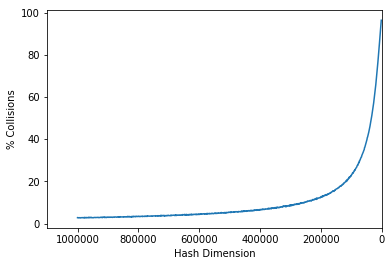

In [56]:
import matplotlib.pyplot as plt
plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data])
plt.xlim(1100000,0)
plt.xlabel("Hash Dimension")
plt.ylabel("% Collisions")
plt.show()

As we can see, the number of collisions grows exponentially as we approach a hash dimension of 0. Often a kind of elbow rule is used to determine the hash dimension.

With this increase of collisions in mind, it would be interesting to know how this impacts the predictive power of machine-learning models. Hash collisions might not be so bad? 

Lets try and figure it out ourselves!

> *Warning, this takes a long time, so run at your own risk!*

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def run_classification(df, hash_dim):
    train,test = train_test_split(df, test_size=0.3)
    X_train = train['TITLE']
    X_test = test['TITLE']
    y_train = train['CATEGORY']
    y_test = test['CATEGORY']

    pipeline = Pipeline(steps=[
        ('hasher', FeatureHasher(n_features=hash_dim, 
                                 input_type="string", 
                                 alternate_sign=False)),
        ('log_reg', LogisticRegression())
    ])

    pipeline.fit(X_train, y_train)
    return accuracy_score(y_test, pipeline.predict(X_test))

df = news_df[:].sample(10000)
le = LabelEncoder()
df['CATEGORY'] = le.fit_transform(df['CATEGORY'])
df['TITLE'] = [tokens(d) for d in df['TITLE']]

# Seems to be an error with calculating total unique words
num_words = len(set.union(*[set(d) for d in df['TITLE']]))

plot_data = list()
for n in range(100000,1000, -1000):
    col = calc_collisions(df['TITLE'], hash_dim=n)
    acc = run_classification(df, hash_dim=n)
    plot_data.append([n,100*col/num_words, acc])

For this calculation, we only took a sample of 10,000 documents to speed up the calculation, and we only look at the lower hash dimensions.

The takeaway from this is that you can **seriously** reduce your dimensionality without losing much predictive power.

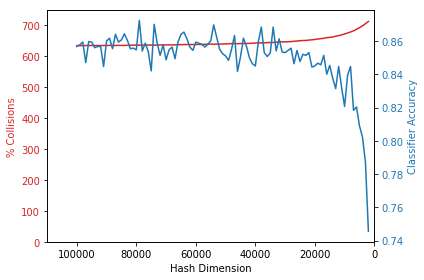

In [88]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel("Hash Dimension")
ax1.set_ylabel('% Collisions', color=color)
ax1.plot([x[0] for x in plot_data], [x[1] for x in plot_data], color=color, 
         label='Collisions')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0,750)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Classifier Accuracy', color=color)
ax2.plot([x[0] for x in plot_data], [x[2] for x in plot_data], color=color, 
         label='Classifier Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xlim(110000,0)
plt.show()